Loading model...



Processing image: '1.png'...
Image processed successfully. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


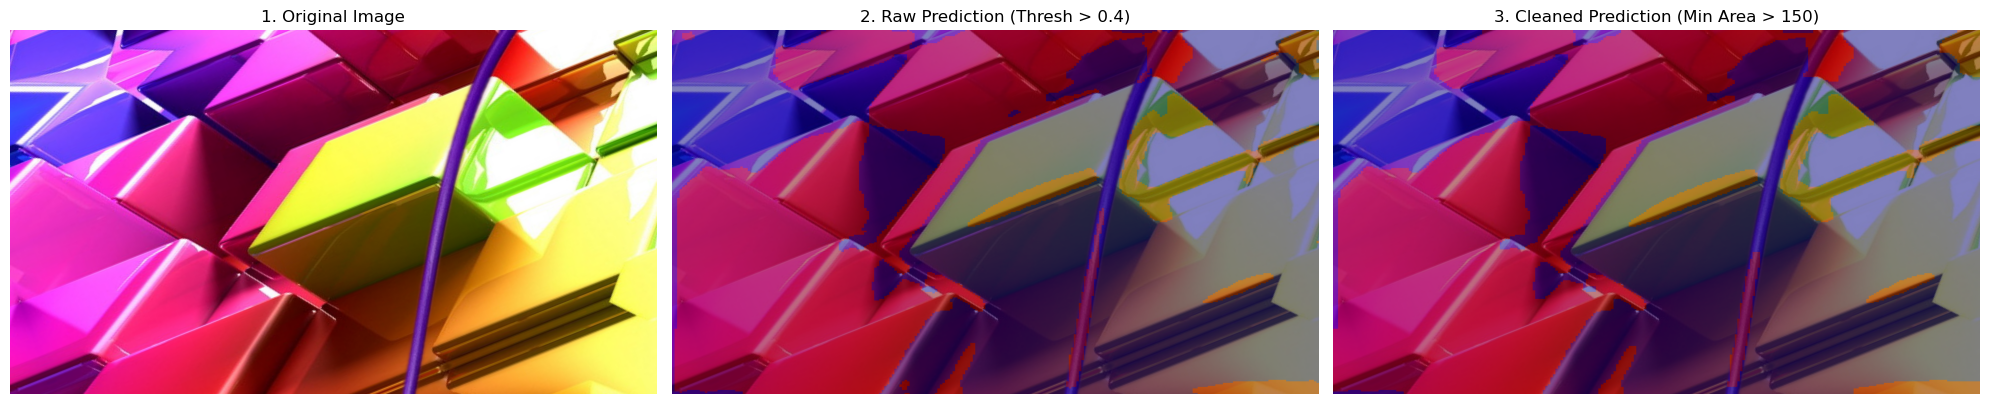

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow.image as tfi

# --- Correct Custom Keras Objects ---
# Acknowledgment: The following class definitions are based on the working code
# you provided. My previous interpretations were incorrect. Thank you for the correction.

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

class EncoderBlock(layers.Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = layers.Dropout(rate)
        self.c2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = layers.MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        }

class DecoderBlock(layers.Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = layers.UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, inputs):
        X, skip_X = inputs
        x = self.up(X)
        c_ = layers.concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
        }

class AttentionGate(layers.Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = layers.UpSampling2D()
        self.BN = layers.BatchNormalization()

    def call(self, inputs):
        X, skip_X = inputs
        x = self.normal(X)
        skip = self.down(skip_X)
        x = layers.Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = layers.Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "bn": self.bn
        }

# --- NEW: Preprocessing copied EXACTLY from the training notebook ---

def preprocess_image_from_notebook(image_path, model_input_size=(256, 256)):
    """
    Exactly replicates the preprocessing function from the training notebook
    using Pillow for loading and TensorFlow for resizing.
    """
    try:
        # Load original image with OpenCV for later visualization (keeps original BGR)
        original_cv2_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if original_cv2_image is None: raise FileNotFoundError(f"Image not found at path: {image_path}")
        original_shape = original_cv2_image.shape[:2]

        # 1. Open with Pillow (ensures RGB format)
        image_pil = Image.open(image_path)
        
        # 2. Convert grayscale to RGB if necessary (as per notebook)
        if image_pil.mode == "L":
            image_pil = image_pil.convert("RGB")

        # 3. Convert to numpy array and normalize to [0, 1]
        image_array = np.array(image_pil) / 255.0

        # 4. Resize using tensorflow.image.resize (as per notebook)
        image_resized = tfi.resize(image_array, model_input_size)

        # 5. Round to 4 decimal places and ensure float32 (as per notebook)
        img_processed = np.round(image_resized, 4).astype(np.float32)
        
        return original_cv2_image, img_processed, original_shape
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def post_process_mask(mask, min_area=100, kernel_size=3):
    """Cleans up a binary mask using morphological operations."""
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_opened, connectivity=8)
    filtered_mask = np.zeros_like(mask_opened)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered_mask[labels == i] = 255
    return filtered_mask / 255.0

def predict_and_visualize(model, processed_image, original_image, original_shape, threshold, min_area):
    """Generates prediction and shows a simplified 3-panel comparison."""
    pred_probability_map = model.predict(processed_image[np.newaxis, ...])[0]
    pred_mask_raw = (pred_probability_map > threshold).astype(np.uint8)
    pred_mask_cleaned = post_process_mask(pred_mask_raw, min_area=min_area)

    # Resize masks up to original image size for a clear overlay
    raw_mask_resized = cv2.resize(pred_mask_raw, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
    cleaned_mask_resized = cv2.resize(pred_mask_cleaned, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
    
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("1. Original Image")
    plt.imshow(original_image_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"2. Raw Prediction (Thresh > {threshold})")
    plt.imshow(original_image_rgb)
    plt.imshow(raw_mask_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(f"3. Cleaned Prediction (Min Area > {min_area})")
    plt.imshow(original_image_rgb)
    plt.imshow(cleaned_mask_resized, cmap='jet', alpha=0.5)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    MODEL_PATH = "AttentionCustomUNet.h5"
    IMAGE_TO_TEST = "1.png"
    PREDICTION_THRESHOLD = 0.4
    MIN_AREA_TO_KEEP = 150

    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
    elif not os.path.exists(IMAGE_TO_TEST):
        print(f"Error: Image file not found at '{IMAGE_TO_TEST}'")
    else:
        print("Loading model...")
        custom_objects = {
            "EncoderBlock": EncoderBlock, "DecoderBlock": DecoderBlock, "AttentionGate": AttentionGate,
            "dice_loss": dice_loss, "iou": iou, "dice_coef": dice_coef
        }
        try:
            model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
            print(f"\nProcessing image: '{IMAGE_TO_TEST}'...")
            
            # Using the new notebook-matched preprocessing function
            original_img, processed_img, original_shape = preprocess_image_from_notebook(IMAGE_TO_TEST)
            
            if processed_img is not None:
                print("Image processed successfully. Making prediction...")
                predict_and_visualize(model, processed_img, original_img, original_shape, PREDICTION_THRESHOLD, MIN_AREA_TO_KEEP)
        except Exception as e:
            print(f"An error occurred while loading the model or predicting: {e}")

